<a href="https://colab.research.google.com/github/StephenMa1511/WQU_CAPSTONE_CTSO/blob/main/Conditional_Strategies_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libaries

In [ ]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.7 MB/s eta 0:00:00


In [ ]:
%matplotlib inline

In [ ]:
import backtrader as bt
import os
import matplotlib
from pathlib import Path
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from google.colab import drive

from datetime import datetime
import yfinance as yf
import backtrader.analyzers as btanalyzers
import itertools


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Display the current directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# Create a path in an OS-independent way
file_path = Path(current_directory) / "drive"/"MyDrive" / "WorldQuantUniversity"/ "MScFE 690 Capstone" / "Price Data"
file_path = file_path / "BTCUSD" / "BINANCE_BTCUSD, 240.csv"
print("OS-independent path:", file_path)

Current Directory: /content
OS-independent path: /content/drive/MyDrive/WorldQuantUniversity/MScFE 690 Capstone/Price Data/BTCUSD/BINANCE_BTCUSD, 240.csv


In [ ]:
current_directory

'/content'

In [ ]:
btc_data = pd.read_csv('/content/drive/Othercomputers/My Computer/WQU Capstone/Price Data/BTCUSD/BINANCE_BTCUSD, 240.csv')
# btc_data = pd.read_csv(file_path)
btc_data.rename(columns={'time': 'datetime', 'Volume':'volume'}, inplace=True)
btc_data['datetime'] = pd.to_datetime(btc_data['datetime'])
btc_data.set_index('datetime', inplace=True)
btc_data = btc_data[['open','high','low','close','volume']]
btc_data.head(), btc_data.isna().sum()

(                                  open         high          low        close  \
 datetime                                                                        
 2020-01-03 08:00:00+00:00  6964.363692  7354.884031  6963.052383  7324.629253   
 2020-01-03 12:00:00+00:00  7325.089963  7334.501608  7246.216883  7262.707099   
 2020-01-03 16:00:00+00:00  7262.707099  7388.403620  7261.145702  7314.903850   
 2020-01-03 20:00:00+00:00  7314.903850  7333.616646  7268.824634  7330.636993   
 2020-01-04 00:00:00+00:00  7317.962851  7319.945808  7288.100128  7291.432264   
 
                                   volume  
 datetime                                  
 2020-01-03 08:00:00+00:00  397058.307372  
 2020-01-03 12:00:00+00:00  413864.999768  
 2020-01-03 16:00:00+00:00  299768.965579  
 2020-01-03 20:00:00+00:00   64404.478881  
 2020-01-04 00:00:00+00:00     108.084964  ,
 open      0
 high      0
 low       0
 close     0
 volume    0
 dtype: int64)

Backtesting the trading strategies, returning CAPM metrics $β$ and $α$, Sharpe and Sortino ratio.

Beta metric ($\beta_s$) highlights the relation between the market represented by a market index like S&P 500 and the portfolio.

$$
\begin{align}
β_s = \frac{Cov(r_s, r_m)}{Var(r_m)}
\end{align}
$$

where $r_s$ is the return of the asset and $r_m$ is the return of the market index.


Alpha metric ($α_s$) allows us to understand if we have a portfolio outperforms or underperforms the benchmark.

$$
\begin{align}
\alpha_s = E[r_s] - r_f - \beta_s \left( E[r_m] - r_f\right)
\end{align}
$$

where $E[r_s]$ is the expected asset's return and $E[r_m]$ is the expected market index returns, $r_f$ is the return of the risk-free asset and $\beta_s$ is the asset's beta.


$$
\begin{align}
Sharpe = \frac{ \mu - r_f }{σ}
\end{align}
$$

where $\mu$ is the mean of the portfolio returns (annualized), $\sigma$ is the volatility of the portfolio returns (annualized), $r_f$ is the risk-free asset.



$$
\begin{align}
Sortino = \frac{\mu - r_f}{\sigma_{downward}}
\end{align}
$$

The Sortino ratio ratio is similar to Sharpe ratio except it only considers the downward volatility. Allowing us to understand the additional benefits for 1% more of low risk.


# Functions define

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0, ret_freq = 1):
  """Calculates the Sharpe ratio of a return series.

  Args:
    returns: A pandas Series or numpy array of returns.
    risk_free_rate: The risk-free rate of return.

  Returns:
    The Sharpe ratio.
  """
  return (np.mean(returns) * (252/ret_freq) - risk_free_rate) / (np.std(returns)*(np.sqrt(252/ret_freq)))
def calculate_annual_return(returns, ret_freq):
  """Calculates the annualized return of a return series.

  Args:
    returns: A pandas Series or numpy array of returns.
    frequency: The number of periods per year.

  Returns:
    The annualized return.
  """
  return np.mean(returns) * 252/ret_freq

def calculate_max_drawdown(returns):
  """Calculates the maximum drawdown of a return series.

  Args:
    returns: A pandas Series or numpy array of returns.

  Returns:
    The maximum drawdown.
  """
  cumulative_returns = (1 + returns).cumprod()
  peak = cumulative_returns.cummax()
  drawdown = (cumulative_returns - peak) / peak
  return drawdown.min()

def calculate_metric(returns, risk_free_rate=0.0, ret_freq = 1):
  """Calculates the Sharpe ratio, annualized return, and maximum drawdown of a return series.

  Args:
    returns: A pandas Series or numpy array of returns"""
  sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate, ret_freq)
  annual_return = calculate_annual_return(returns, ret_freq)
  max_drawdown = calculate_max_drawdown(returns)
  return sharpe_ratio, annual_return, max_drawdown


# Methodologies

In this Capstone, We'll be using Backtrader libary for generating the performance result for our trading strategies

# Mean Reversion Strategies

Strategy 1 - Mean reversion

Buy if :

	Price < Lower Bollngerband and MACD histogram[0] (most recent value) > MACD histogram[1] (second recent value)

	Exit if price > ema20 + buffer * atr

Sell if :

	Price > Upper Bollngerband and MACD histogram[0] (most recent value) < MACD histogram[1] (second recent value)

	Exit if price < ema20 - buffer *atr

In [ ]:
# Design the strategy
class EmaMacdStrategy(bt.Strategy):
    params = (
        ('ema_period', 20),
        ('macd_fast', 3),
        ('macd_slow', 10),
        ('macd_signal', 16),
        ('atr_period', 20),

        ('boll_period', 20),  # Bollinger Band period
        ('boll_devfactor', 2),  # Number of standard deviations for the Bollinger Bands
        ('exit_atr_scale', 0.3), # atr buffer to ema when exit

        ('risk_percent', 0.2), # Risk 10% of equity per trade
        ('fix_position_size', 1),
        ('logging', True) # Logging flag
    )

    def __init__(self):
        # Indicators
        self.ema = bt.indicators.EMA(self.data.close, period=self.params.ema_period)
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd_fast,
                                       period_me2=self.params.macd_slow,
                                       period_signal=self.params.macd_signal)
        self.boll = bt.indicators.BollingerBands(self.data.close,
                                                 period=self.params.boll_period,
                                                 devfactor=self.params.boll_devfactor)
        self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period)



    def next(self):
        price = self.data.close[0]
        ema = self.ema[0]
        exit_price_buy = ema + self.params.exit_atr_scale * self.atr[0]
        exit_price_sell = ema - self.params.exit_atr_scale * self.atr[0]

        upper_band = self.boll.lines.top[0]  # Upper Bollinger Band
        lower_band = self.boll.lines.bot[0]  # Lower Bollinger Band
        macd_line = self.macd.macd
        signal_line = self.macd.signal

        # Calculate the position size based on a percentage of current equity
        cash = self.broker.get_cash()
        risk_amount = cash * self.params.risk_percent
        if self.params.fix_position_size > 0:
            position_size = self.params.fix_position_size
        else:
            position_size = risk_amount // price  # Integer number of shares/contracts
        # self.log(f'Calculated position size: {position_size} shares/contracts')
        # self.log(f'Cash in account: {cash} ')

        # Buy Condition: Price is below the lower Bollinger Band
        # and the MACD line[0] > MACD line[-1]
        if price < lower_band and macd_line[0] > macd_line[-1]:
            if not self.position:
                self.buy(size = position_size)
                # self.log(f'BUY signal: price={price}, lower_band={lower_band}, MACD crossover')

        # Exit Buy Condition: Price goes above the exit price
        elif price > exit_price_buy and self.position and self.position.size > 0:
            self.close()
            self.log(f'EXIT BUY: price={price}, EMA={ema}')

        # Sell Condition: Price is above the upper Bollinger Band
        # and the MACD line[0] < MACD line[-1]
        elif price > upper_band and macd_line[0] < macd_line[-1]:
            if not self.position:
                self.sell(size = position_size)
                # self.log(f'SELL signal: price={price}, upper_band={upper_band}, MACD crossover')

        # Exit Sell Condition: Price goes below the EMA
        elif price < exit_price_sell and self.position and self.position.size < 0:
            self.close()
            # self.log(f'EXIT SELL: price={price}, EMA={ema}')

    # def notify_order(self, order):
    #     if order.status in [order.Completed]:
    #         if order.isbuy():
    #             self.log(f'BUY executed at {order.executed.price}, next bar open')
    #         elif order.issell():
    #             self.log(f'SELL executed at {order.executed.price}, next bar open')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                if self.position.size > 0:  # Opening a long position
                    self.log(f'BUY executed at {order.executed.price}, position_size = {order.executed.size}')
                elif self.position.size == 0:  # Closing a short position
                    self.log(f'CLOSE SHORT executed at {order.executed.price}, position_size = {order.executed.size}')
            elif order.issell():
                if self.position.size < 0:  # Opening a short position
                    self.log(f'SELL executed at {order.executed.price}, position_size = {order.executed.size}')
                elif self.position.size == 0:  # Closing a long position
                    self.log(f'CLOSE LONG executed at {order.executed.price}, position_size = {order.executed.size}')

        # Handle rejected, canceled, or margin orders
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order {order.getstatusname()}')

    def log(self, txt, dt=None):
        """ Logging function for this strategy """
        if self.params.logging:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()} - {txt}')



cerebroMR = bt.Cerebro()
cerebroMR.addstrategy(EmaMacdStrategy,fix_position_size = 1, logging = False)

# Load Data
data = bt.feeds.PandasData(dataname=btc_data)
cerebroMR.adddata(data)

# Set initial cash
cerebroMR.broker.setcash(100000.0)

# Set commission
cerebroMR.broker.setcommission(commission=0.001)

# Add TimeReturn analyzer
cerebroMR.addanalyzer(btanalyzers.TimeReturn, _name='timereturn')

# Run the strategy
print('Starting Portfolio Value: %.2f' % cerebroMR.broker.getvalue())
results  = cerebroMR.run()
print('Final Portfolio Value: %.2f' % cerebroMR.broker.getvalue())

return_series = results[0].analyzers.timereturn.get_analysis()

# Convert the return series to a pandas DataFrame
return_df_MR = pd.DataFrame.from_dict(return_series, orient='index', columns=['Returns'])

# Show the first few rows of the return DataFrame
print(return_df_MR.head())

# #to plot the return series:
# return_df_MR.plot(title='Return Series')
# plt.show()



# %matplotlib inline
# cerebroMR.plot(iplot=False)
# plt.show()

# (return_df_MR + 1).cumprod().plot() # get the return cumprod plot

Starting Portfolio Value: 100000.00
Final Portfolio Value: 107545.37
            Returns
2020-01-03      0.0
2020-01-04      0.0
2020-01-05      0.0
2020-01-06      0.0
2020-01-07      0.0


# SuperTrend strategy


Strategy 2 -  SuperTrend - Trend Following

Get supertrend, and direction values from supertrend indicator:   

    [supertrend, direction] = ta.supertrend(input(5, "factor"), input.int(10, "atrPeriod"))

Buy condition (direction < 0):

    If the current Supertrend is increasing compared to two periods ago, open a long position.
    
    If a short position is currently open, close it.

Sell condition (direction > 0):

		If the current Supertrend is decreasing compared to three periods ago, open a short position.

		If a long position is currently open, close it.
    

In [ ]:
class PineSupertrend(bt.Indicator):
    lines = ('supertrend', 'direction')
    params = (
        ('factor', 3),         # Multiplier (equivalent to Pine Script 'factor')
        ('atr_period', 10),    # ATR period (equivalent to Pine Script 'atrPeriod')
    )

    def __init__(self):
        # Middle price (hl2 = (high + low) / 2)
        hl2 = (self.data.high + self.data.low) / 2.0

        # ATR calculation
        self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period)

        # Upper and lower bands
        self.l.upperband = hl2 + self.params.factor * self.atr
        self.l.lowerband = hl2 - self.params.factor * self.atr

        # Supertrend and direction
        self.l.supertrend = bt.If(self.data.close > self.l.upperband, self.l.upperband, self.l.lowerband)
        # self.l.direction = 1   # To track the direction (1 = uptrend, -1 = downtrend)

    def next(self):
        # Previous values for comparison
        prev_supertrend = self.l.supertrend[-1]
        prev_upperband = self.l.upperband[-1]
        prev_lowerband = self.l.lowerband[-1]
        prev_direction = self.l.direction[-1]

        # Update the bands
        lowerband = self.l.lowerband[0]
        upperband = self.l.upperband[0]

        # Adjust the bands to ensure they don't reverse prematurely
        lowerband = lowerband if (lowerband > prev_lowerband or self.data.close[-1] < prev_lowerband) else prev_lowerband
        upperband = upperband if (upperband < prev_upperband or self.data.close[-1] > prev_upperband) else prev_upperband

        # Determine direction
        if prev_supertrend == prev_upperband:
            direction = -1 if self.data.close[0] > upperband else 1
        else:
            direction = 1 if self.data.close[0] < lowerband else -1

        # Set the supertrend value based on the direction
        self.l.supertrend[0] = lowerband if direction == -1 else upperband
        self.l.direction[0] = direction

## Class SupertrendStrategy

In [ ]:
class SupertrendStrategy(bt.Strategy):
    params = (
        ('factor', 2),  # Supertrend factor (multiplier)
        ('atr_period', 10),  # ATR period for Supertrend
        ('lag_factor', 1),
        ('risk_percent', 0.2), # Risk % of equity per trade
        ('fix_position_size', 1), # fix positon size
        ('logging', True) # Logging flag

    )

    def __init__(self):
        # Add the custom Supertrend indicator
        self.supertrend = PineSupertrend(self.data, factor=self.params.factor, atr_period=self.params.atr_period)

    def next(self):
        price = self.data.close[0]
        lag = self.params.lag_factor
        supertrend = self.supertrend.lines.supertrend[0]
        direction = self.supertrend.lines.direction[0]
        prev_supertrend = self.supertrend.lines.supertrend[-lag]
        position_size = self.position.size


        # Calculate the position size based on a percentage of current equity
        cash = self.broker.get_cash()
        risk_amount = cash * self.params.risk_percent
        if self.params.fix_position_size > 0:
            position_size = self.params.fix_position_size
        else:
            position_size = risk_amount // price  # Integer number of shares/contracts
        # self.log(f'Calculated position size: {position_size} shares/contracts')
        # self.log(f'Cash in account: {cash} ')

        # Buy Condition (long): direction < 0 and Supertrend rising
        if direction < 0:
            if supertrend > prev_supertrend:
                if not self.position:  # If we are not in a position, enter a long position
                    self.buy(size = position_size)
                    self.log(f'BUY executed at {self.data.close[0]}')
            elif position_size < 0:  # If in a short position, close the short position
                self.close()
                # self.log(f'CLOSE SHORT executed at {self.data.close[0]}')

        # Sell Condition (short): direction > 0 and Supertrend falling
        elif direction > 0:
            if supertrend < prev_supertrend:
                if not self.position:  # If we are not in a position, enter a short position
                    self.sell(size = position_size)
                    # self.log(f'SELL executed at {self.data.close[0]}')
            elif position_size > 0:  # If in a long position, close the long position
                self.close()
                # self.log(f'CLOSE LONG executed at {self.data.close[0]}')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                if self.position.size > 0:  # Opening a long position
                    self.log(f'BUY executed at {order.executed.price}, position_size = {order.executed.size}')
                elif self.position.size == 0:  # Closing a short position
                    self.log(f'CLOSE SHORT executed at {order.executed.price}, position_size = {order.executed.size}')
            elif order.issell():
                if self.position.size < 0:  # Opening a short position
                    self.log(f'SELL executed at {order.executed.price}, position_size = {order.executed.size}')
                elif self.position.size == 0:  # Closing a long position
                    self.log(f'CLOSE LONG executed at {order.executed.price}, position_size = {order.executed.size}')

    def log(self, txt, dt=None):
        """ Logging function for this strategy """
        if self.params.logging:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()} - {txt}')


In [ ]:
cerebroST = bt.Cerebro()
cerebroST.addstrategy(SupertrendStrategy,fix_position_size = 1)

# Load Data
data = bt.feeds.PandasData(dataname=btc_data)
cerebroST.adddata(data)

# Set initial cash
cerebroST.broker.setcash(100000.0)

# Set commission
cerebroST.broker.setcommission(commission=0.001)

# Add TimeReturn analyzer
cerebroST.addanalyzer(btanalyzers.TimeReturn, _name='timereturn')

# Run the strategy
print('Starting Portfolio Value: %.2f' % cerebroST.broker.getvalue())
results_ST  = cerebroST.run()
print('Final Portfolio Value: %.2f' % cerebroST.broker.getvalue())

return_series_ST = results_ST[0].analyzers.timereturn.get_analysis()

# Convert the return series to a pandas DataFrame
return_df_ST = pd.DataFrame.from_dict(return_series_ST, orient='index', columns=['Returns'])

# Show the first few rows of the return DataFrame
print(return_df_ST.head())

# #to plot the return series:
# return_df.plot(title='Return Series')
# plt.show()


# %matplotlib inline
# cerebroST.plot(iplot=False)
# plt.show()

Starting Portfolio Value: 100000.00
2020-01-05 - BUY executed at 7459.3217996
2020-01-05 - BUY executed at 7457.5171088, position_size = 1
2020-01-19 - CLOSE LONG executed at 8671.096115, position_size = -1
2020-01-19 - SELL executed at 8626.8640885, position_size = -1
2020-01-19 - CLOSE SHORT executed at 8637.9525885, position_size = 1
2020-01-20 - BUY executed at 8665.063584
2020-01-20 - BUY executed at 8661.0375102, position_size = 1
2020-02-20 - CLOSE LONG executed at 9640.9144, position_size = -1
2020-02-20 - SELL executed at 9598.8233061, position_size = -1
2020-02-20 - CLOSE SHORT executed at 9565.6104, position_size = 1
2020-02-20 - BUY executed at 9621.19865
2020-02-21 - BUY executed at 9620.4851428, position_size = 1
2020-03-08 - CLOSE LONG executed at 8452.4257824, position_size = -1
2020-03-08 - SELL executed at 8366.2675316, position_size = -1
2020-03-09 - CLOSE SHORT executed at 7819.2474752, position_size = 1
2020-03-09 - BUY executed at 7932.4399053
2020-03-10 - BUY exe

# 1st step summary

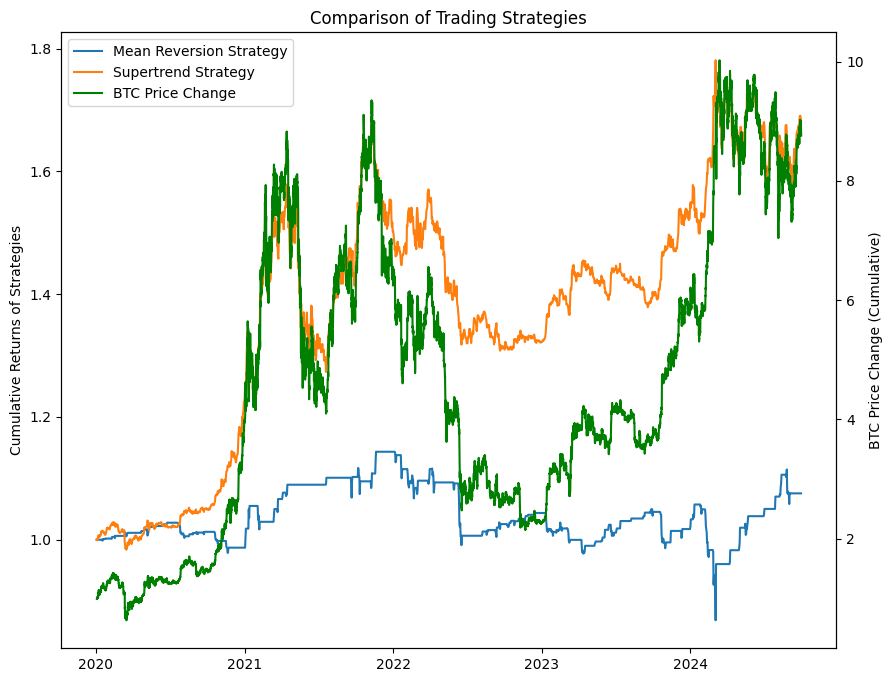

Strategy,Supertrend,Mean Reversion,BTC_BUYnHOLD
Sharpe Ratio,1.610617,0.423582,0.864648
Annual Return,0.505124,0.082771,0.462354
Max Drawdown,-0.219612,-0.240208,-0.770405


In [ ]:
fig, ax1 = plt.subplots(figsize = (10,8))

# Plot return_df_MR and return_df_ST on the same axes
ax1.plot((return_df_MR + 1).cumprod(), label='Mean Reversion Strategy')
ax1.plot((return_df_ST + 1).cumprod(), label='Supertrend Strategy')
ax1.set_ylabel('Cumulative Returns of Strategies')

# Create a secondary y-axis for btc_data.close
ax2 = ax1.twinx()
ax2.plot((btc_data.close.pct_change() + 1).cumprod(), color='green', label='BTC Price Change')
ax2.set_ylabel('BTC Price Change (Cumulative)')


# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')

# Set the title
plt.title('Comparison of Trading Strategies')

# Show the plot
plt.show()


# calculate initial metrics
ret_freq = 4/24
risk_free_rate = 0

sharpe_ratio_ST, annual_return_ST, max_drawdown_ST = calculate_metric(return_df_ST['Returns'], risk_free_rate, ret_freq)
sharpe_ratio_MR, annual_return_MR, max_drawdown_MR = calculate_metric(return_df_MR['Returns'], risk_free_rate, ret_freq )
sharpe_ratio_BTC, annual_return_BTC, max_drawdown_BTC = calculate_metric(btc_data.close.pct_change(), risk_free_rate, ret_freq)



df_metrics = pd.DataFrame({
    'Strategy': ['Supertrend', 'Mean Reversion', 'BTC_BUYnHOLD'],
    'Sharpe Ratio': [sharpe_ratio_ST, sharpe_ratio_MR, sharpe_ratio_BTC],
    'Annual Return': [annual_return_ST, annual_return_MR, annual_return_BTC],
    'Max Drawdown': [max_drawdown_ST, max_drawdown_MR, max_drawdown_BTC]
})

# Set the index to the 'Strategy' column
df_metrics = df_metrics.set_index('Strategy').T

display(df_metrics)

# Generate Control Features

We'll generate around 1000 parameter configurations for each strategies

In [ ]:
def run_grid_search(strategy, param_grid, btc_data, cash = 100000, commission = 0.001, logging = False):
    """
    Run a grid search on SupertrendStrategy with the given parameter grid.

    :param param_grid: Dictionary where keys are parameter names and values are lists of parameter values to search.
    :param btc_data: The dataset to be used for the strategy.

    :return: A DataFrame with parameter values and return series.
    """

    # Get the list of parameter names and their values
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())

    # List to store the results
    results_list = []

    # Create all combinations of the parameters using itertools.product
    for param_combination in itertools.product(*param_values):

        # Create a dictionary of parameter names and their current values for this iteration
        params_dict = dict(zip(param_names, param_combination))

        # Set up Cerebro
        cerebro = bt.Cerebro()

        # Add the strategy with the current parameter combination and disable logging
        cerebro.addstrategy(strategy, **params_dict, logging=logging)

        # Load Data (Replace with your actual data feed)
        data = bt.feeds.PandasData(dataname=btc_data)  # Assume btc_data is your dataset
        cerebro.adddata(data)

        # Set initial cash
        cerebro.broker.setcash(100000.0)

        # Set commission
        cerebro.broker.setcommission(commission=0.001)

        # Add TimeReturn analyzer to capture returns
        cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

        # Run the strategy
        results = cerebro.run()

        # Get the return series from the analyzer
        return_series = results[0].analyzers.timereturn.get_analysis()

        # Convert the return series to a DataFrame
        return_df = pd.DataFrame.from_dict(return_series, orient='index', columns=['Returns'])

        # Append the parameter combination and the return_df to the results list
        results_list.append({**params_dict, 'return_df': return_df})

    # Convert results list to a DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df

## Supertrend Strategy


In [ ]:
factor_values = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]  # Example values for 'factor'
atr_period_values = np.linspace(10,20,11).astype(int)  # Example values for 'atr_period'
lag_factor_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]
param_grid = {'factor': factor_values, 'atr_period': atr_period_values, 'lag_factor': lag_factor_values}

# factor_values = [1, 1.5]  # Example values for 'factor'
# atr_period_values = [10, 11]  # Example values for 'atr_period'
# lag_factor_values = [1, 2]
# param_grid = {'factor': factor_values, 'atr_period': atr_period_values, 'lag_factor': lag_factor_values}

In [ ]:
grid_results_ST = run_grid_search(SupertrendStrategy, param_grid, btc_data)

In [ ]:

grid_results_ST

,factor,atr_period,lag_factor,return_df
0,1.0,10,1,Returns 2020-01-03 0.000000 2020...
1,1.0,10,2,Returns 2020-01-03 0.000000 2020...
2,1.0,10,3,Returns 2020-01-03 0.000000 2020...
3,1.0,10,4,Returns 2020-01-03 0.000000 2020...
4,1.0,10,5,Returns 2020-01-03 0.000000 2020...
...,...,...,...,...
1095,5.5,20,6,Returns 2020-01-03 0.000000 2020...
1096,5.5,20,7,Returns 2020-01-03 0.000000 2020...
1097,5.5,20,8,Returns 2020-01-03 0.000000 2020...
1098,5.5,20,9,Returns 2020-01-03 0.000000 2020...


In [ ]:
# prompt: save grid_results_ST to drive
grid_results_ST.to_pickle( '/content/drive/Othercomputers/My Computer/WQU Capstone/Price Data/BTCUSD/grid_results_ST.pkl')

print("The entire results_df (with nested return_df) saved as a pickle file.")

The entire results_df (with nested return_df) saved as a pickle file.


In [ ]:
grid_results_ST.to_pickle( '/content/drive/MyDrive/MScFE 690 Capstone/week4/grid_results_ST.pkl')

In [ ]:
loaded_results_df = pd.read_pickle( '/content/drive/MyDrive/MScFE 690 Capstone/week4/grid_results_ST.pkl')

## Mean reversion grid search


In [ ]:
        ('boll_period', 20),  # Bollinger Band period
        ('boll_devfactor', 2),  # Number of standard deviations for the Bollinger Bands
        ('exit_atr_scale', 0.3), # atr buffer to ema when exit


In [ ]:
boll_period_values = list(np.linspace(10,30,11).astype(int))  # Example values for 'boll_period'
boll_devfactor_values = list(np.linspace(1,3,11).astype(float))  # Example values for 'boll_devfactor'
exit_atr_scale_values = list(np.linspace(1,2,11).astype(float)) #  # Example values for 'exit_atr_scale'
param_grid_MR = {'boll_period': boll_period_values, 'boll_devfactor': boll_devfactor_values, 'exit_atr_scale': exit_atr_scale_values}


In [ ]:
boll_period_values =[10,12,14,16,18,20,22,24,26,28,30] # Example values for 'boll_period'
boll_devfactor_values = [1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3] # Example values for 'boll_devfactor'
exit_atr_scale_values = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]# Example values for 'exit_atr_scale'
param_grid_MR = {'boll_period': boll_period_values, 'boll_devfactor': boll_devfactor_values, 'exit_atr_scale': exit_atr_scale_values}


In [ ]:
grid_results_MR = run_grid_search(EmaMacdStrategy, param_grid_MR, btc_data)

In [ ]:
grid_results_MR

,boll_period,boll_devfactor,exit_atr_scale,return_df
0,10,1.0,0.0,Returns 2020-01-03 0.000000 2020...
1,10,1.0,0.2,Returns 2020-01-03 0.000000 2020...
2,10,1.0,0.4,Returns 2020-01-03 0.000000 2020...
3,10,1.0,0.6,Returns 2020-01-03 0.000000 2020...
4,10,1.0,0.8,Returns 2020-01-03 0.000000 2020...
...,...,...,...,...
1326,30,3.0,1.2,Returns 2020-01-03 0.0 2020-0...
1327,30,3.0,1.4,Returns 2020-01-03 0.0 2020-0...
1328,30,3.0,1.6,Returns 2020-01-03 0.0 2020-0...
1329,30,3.0,1.8,Returns 2020-01-03 0.0 2020-0...


In [ ]:
# prompt: save grid_results_ST to drive
grid_results_MR.to_pickle( '/content/drive/Othercomputers/My Computer/WQU Capstone/Price Data/BTCUSD/grid_results_MR.pkl')
grid_results_MR.to_pickle( '/content/drive/MyDrive/MScFE 690 Capstone/week4/grid_results_MR.pkl')

print("The entire results_df (with nested return_df) saved as a pickle file.")

The entire results_df (with nested return_df) saved as a pickle file.
